## 1、后量化训练（线性量化）
https://zhuanlan.zhihu.com/p/156835141

非对称量化：

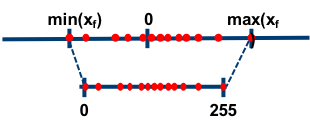

scale:
> s = rmax - rmin / qmax - qmin

zero point:
> z = round(qmax - rmax / s)

### 1. 量化基本公式

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

In [2]:
def calcu_scale_and_zeropoint(min_val, max_val, num_bits=8, is_per_channel_quantize=False):
    # 计算 scale 和 zero_point 的基本公式
    # is_per_channel_quantize 决定是按照逐通道量化还是按照逐层量化来计算 scale 和 zero_point 
    q_min = 0.
    q_max = 2. ** num_bits - 1
    
    # 匿名函数，计算 scale 和 zero_point
    calcu_scale =  lambda max_val, min_val : float((max_val - min_val) / (q_max - q_min))
    calcu_zero_point = lambda max_val, scale :  np.clip(int(q_max - max_val / scale), q_min, q_max)
    
    # 是否是逐通道量化
    if  is_per_channel_quantize:
        scale = []
        zero_point = []

        for i in range(len(min_val)):
            scale.append(calcu_scale(max_val[i], min_val[i]))
            zero_point.append( calcu_zero_point(max_val[i], scale[i]))  
            
    else:
        scale = calcu_scale(max_val, min_val)
        zero_point = calcu_zero_point(max_val, scale)
        
    return scale, zero_point


In [3]:
def quantize_tensor(x, scale, zero_point, num_bits=8, signed=False, is_per_channel_quantize=False ):
    # 计算 scale 和 zero_point 的基本公式
    # is_per_channel_quantize 决定是按照逐通道量化还是按照逐层量化
    if signed:
        q_min = - 2. ** (num_bits - 1)
        q_max = 2. ** (num_bits - 1) - 1.
    else:
        q_min = 0.
        q_max = 2. ** num_bits -1.
    
    if is_per_channel_quantize:
        q_x = torch.zeros(x.shape)
        for i in range(len(scale)):
            q_x[i,:,:,:] = x[i,:,:,:] /scale[i] + zero_point[i]
            q_x[i,:,:,:].clamp_(0, 255).round()
            
    else:
        q_x = x / scale + zero_point
        q_x.clamp_(q_min, q_max).round()  # q=round(r/S+Z)
        
    return q_x

def dequantize_tensor(q_x, scale, zero_point, is_per_channel_quantize=False ):
    
    if is_per_channel_quantize:
        x = torch.zeros(q_x.shape)
        for i in range(len(scale)):
            x[i,:,:,:] = scale[i] * (q_x[i,:,:,:] - zero_point[i])
            
    else:
        x = scale * (q_x -zero_point)
        
    return x

In [4]:
def calcu_max_and_min(x, min_val,  max_val, is_per_channel_quantize=False ):
    # 根据最大值和最小值统计 上下限
    calcu_max = lambda x, max_val: max(0, x.max()) if max_val is None \
                       else max(0, x.max(), max_val)
    calcu_min = lambda x, min_val: min(0, x.min()) if min_val is None \
                       else min(0, x.min(), min_val)
    if is_per_channel_quantize:
#         max_val =[calcu_max(x[i,:,:,:], max_val[i]) for i in range(len(x[0]))]    
#         min_val =[calcu_min(x[i,:,:,:], min_val[i]) for i in range(len(x[0]))]    这样写也行，不过读起来差一点
        new_max_val = []
        new_min_val = []
        for i in range(len(x)):
            if max_val == None or  max_val[i] == None:
                new_max_val.append(calcu_max(x[i,:,:,:], None))
            else:
                new_max_val.append(calcu_max(x[i,:,:,:], max_val[i]))
            if min_val == None or  min_val[i] == None:
                new_min_val.append(calcu_min(x[i,:,:,:], None))
            else:
                new_min_val.append(calcu_min(x[i,:,:,:], min_val[i]))
            
    else:
        new_max_val = calcu_max(x, max_val)
        new_min_val = calcu_min(x, min_val)
        
    return new_min_val, new_max_val

### 2. 封装成类

In [5]:
class QParam:
    def __init__(self, num_bits=8):
        self.num_bits = num_bits
        self.scale = None
        self.zero_point = None
        self.min = None
        self.max = None
    
    def update(self, tensor, is_per_channel_quantize=False):
        self.min, self.max = calcu_max_and_min(tensor, self.min, self.max, is_per_channel_quantize)
        self.scale, self.zero_point = calcu_scale_and_zeropoint(self.min, self.max, self.num_bits, is_per_channel_quantize)
        
    def quantize_tensor(self, tensor, is_per_channel_quantize=False):
        return quantize_tensor(tensor, self.scale, self.zero_point, self.num_bits, False, is_per_channel_quantize)
    
    def dequantize_tensor(self, q_x, is_per_channel_quantize=False):
        return dequantize_tensor(q_x, self.scale, self.zero_point, is_per_channel_quantize)        

### 3、量化网络基类定义

In [6]:
class QModule(nn.Module):
    def __init__(self, has_qin=True, has_qout=True, num_bits=8):
        # 指定量化的位数外，还需指定是否提供量化输入 (qin) 及输出参数 (qout)
        # 不是每一个网络模块都需要统计输入的 min、max，大部分中间层都是用上一层的 qout 来作为自己的 qin 的，
        # 另外有些中间层的激活函数也是直接用上一层的 qin 来作为自己的 qin 和 qout。
        super(QModule, self).__init__()
        if has_qin:
            self.q_in = QParam(num_bits)
        if has_qout:
            self.q_out = QParam(num_bits)
    
    def freeze(self):
        # 函数会在统计完 min、max 后发挥作用
        # 很多项是可以提前计算好的，freeze 就是把这些项提前固定下来
        # 同时也将网络的权重由浮点实数转化为定点整数。
        pass
    
    def quantize_inference(self, x):
        # 在量化 inference 的时候会使用
        raise NotImplementedError('quantize_inference should be implemented.')

### 4、伪量化定义

In [7]:
# 前向推导中，先量化再反量化，引入噪声
class FakeQuantize(Function):

    @staticmethod
    def forward(ctx, x, qparam, is_per_channel_quantize=False):
        x = qparam.quantize_tensor(x, is_per_channel_quantize)
        x = qparam.dequantize_tensor(x, is_per_channel_quantize)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None

fake_quantize = FakeQuantize.apply

### 5、量化卷积层类的定义
<img src="https://www.zhihu.com/equation?tex=a%3D%5Csum_%7Bi%7D%5EN+w_i+x_i%2Bb+%5Ctag%7B1%7D+" alt="[公式]" style="zoom:80%;" />
由此得到量化的公式
<img src="https://www.zhihu.com/equation?tex=S_a+%28q_a-Z_a%29%3D%5Csum_%7Bi%7D%5EN+S_w%28q_w-Z_w%29S_x%28q_x-Z_x%29%2BS_b%28q_b-Z_b%29+%5Ctag%7B2%7D+" alt="[公式]" style="zoom:80%;" />
<img src="https://www.zhihu.com/equation?tex=q_a%3D%5Cfrac%7BS_w+S_x%7D%7BS_a%7D%5Csum_%7Bi%7D%5EN+%28q_w-Z_w%29%28q_x-Z_x%29%2B%5Cfrac%7BS_b%7D%7BS_a%7D%28q_b-Z_b%29%2BZ_a+%5Ctag%7B3%7D+" alt="[公式]" style="zoom:80%;" />


> <img src="./image/image.png" style="zoom:60%;" />

经过调整：

<img src="https://www.zhihu.com/equation?tex=%5Cbegin%7Balign%7D+q_a%26%3D%5Cfrac%7BS_w+S_x%7D%7BS_a%7D%28%5Csum_%7Bi%7D%5EN%28q_w-Z_w%29%28q_x-Z_x%29%2Bq_b%29%2BZ_a+%5Cnotag+%5C%5C+%26%3DM%28%5Csum_%7Bi%7D%5EN+q_wq_x-%5Csum_i%5EN+q_wZ_x-%5Csum_i%5EN+q_xZ_w%2B%5Csum_i%5ENZ_wZ_x%2Bq_b%29%2BZ_a+%5Ctag%7B4%7D+%5Cend%7Balign%7D+" alt="[公式]" style="zoom:80%;" />

In [8]:
class QConv2d(QModule):
    def __init__(self, conv_module, has_qin=True, has_qout=True, num_bits=8, is_per_channel_quantize=False):
        super(QConv2d, self).__init__(has_qin, has_qout, num_bits)
        self.num_bits = num_bits
        self.conv_module = conv_module
        self.q_weight = QParam(num_bits=num_bits)
        self.weight_quantize_type = is_per_channel_quantize
        
    def forward(self, x):
        if hasattr(self, 'q_in'):
            # 更新量化输入 q_in 的参数
            self.q_in.update(x)
            x = fake_quantize(x, self.q_in)
            
        self.q_weight.update(self.conv_module.weight.data, self.weight_quantize_type)
        x = F.conv2d(input = x, 
                     weight = fake_quantize(self.conv_module.weight, self.q_weight, self.weight_quantize_type), 
                     bias = self.conv_module.bias, 
                     stride = self.conv_module.stride,
                     padding = self.conv_module.padding, 
                     dilation=self.conv_module.dilation, 
                     groups = self.conv_module.groups)
        
        if hasattr(self, 'q_out'):
            self.q_out.update(x)
            x = fake_quantize(x, self.q_out)
            
        return x
    
    def freeze(self, q_in=None, q_out=None):
        if hasattr(self, 'q_in') and q_in is not None:
            raise ValueError('q_in has been provided in init function.')
        if not hasattr(self, 'q_in') and q_in is None:
            raise ValueError('q_in is not existed, should be provided.')

        if hasattr(self, 'q_out') and q_out is not None:
            raise ValueError('q_out has been provided in init function.')
        if not hasattr(self, 'q_out') and q_out is None:
            raise ValueError('q_out is not existed, should be provided.')
            
        if q_in is not None:
            self.q_in = q_in
        if q_out is not None:
            self.q_out = q_out
        
        
        if self.weight_quantize_type:
            # 计算 M = s_w * s_in / s_out
            self.M = [self.q_weight.scale[i] * self.q_in.scale / self.q_out.scale 
                      for i in range(len(self.q_weight.scale))]
            # 计算量化后的权重
            quantized_weight = self.q_weight.quantize_tensor(self.conv_module.weight.data, self.weight_quantize_type)
            for i in range(len(self.q_weight.zero_point)):
                self.conv_module.weight.data[i] = quantized_weight[i] - self.q_weight.zero_point[i]
            # 计算量化后的偏置
#             quantized_bias = [self.q_weight.scale[i] * self.q_in.scale for i in range(len(self.q_weight.scale))]
#             quantized_zero_point = [0]*len(self.q_weight.scale)
#             self.conv_module.bias.data = quantize_tensor(self.conv_module.bias.data, scale=quantized_bias,
#                                                      zero_point=quantized_zero_point, num_bits=32, signed=True, 
#                                                          is_per_channel_quantize=self.weight_quantize_type)
        else:
            # 计算 M = s_w * s_in / s_out
            self.M = self.q_weight.scale * self.q_in.scale / self.q_out.scale
            # 计算量化后的权重
            self.conv_module.weight.data = self.q_weight.quantize_tensor(self.conv_module.weight.data) \
                                        - self.q_weight.zero_point
            # 计算量化后的偏置
#             self.conv_module.bias.data = quantize_tensor(self.conv_module.bias.data, scale=self.q_in.scale * self.q_weight.scale,
#                                                          zero_point=0, num_bits=32, signed=True)
        self.conv_module.bias.data = quantize_tensor(self.conv_module.bias.data, scale=self.q_in.scale * np.mean(self.q_weight.scale),
                                                         zero_point=0, num_bits=32, signed=True)
    
    def quantize_inference(self, x):
        x = x - self.q_in.zero_point
        x = self.conv_module(x)
        if self.weight_quantize_type:
            for i in range(len(self.M)):
                x[:,i,:,:] = x[:,i,:,:] * self.M[i]
        else:
            x = self.M * x
        x.round_()
        x = x + self.q_out.zero_point
        x.clamp_(0., 2. ** self.num_bits - 1.).round_()
        return x#.to(torch.uint8)

### 5、量化线性层类的定义

In [9]:
class QLinear(QModule):
    def __init__(self, fc_module, has_qin=True, has_qout=True, num_bits=8):
        super(QLinear, self).__init__(has_qin, has_qout, num_bits)
        self.num_bits = num_bits
        self.fc_module = fc_module
        self.q_weight = QParam(num_bits=num_bits)
        
    def forward(self, x):
        if hasattr(self, 'q_in'):
            self.q_in.update(x)
            x = fake_quantize(x)
            
        self.q_weight.update(self.fc_module.weight.data)
        x = F.linear(input = x, 
                     weight = fake_quantize(self.fc_module.weight, self.q_weight,False), 
                     bias = self.fc_module.bias)
        
        if hasattr(self, 'q_out'):
            self.q_out.update(x, is_per_channel_quantize=False)
            x = fake_quantize(x, self.q_out,False)
            
        return x
    
    def freeze(self, q_in=None, q_out=None):
        if hasattr(self, 'q_in') and q_in is not None:
            raise ValueError('q_in has been provided in init function.')
        if not hasattr(self, 'q_in') and q_in is None:
            raise ValueError('q_in is not existed, should be provided.')

        if hasattr(self, 'q_out') and q_out is not None:
            raise ValueError('q_out has been provided in init function.')
        if not hasattr(self, 'q_out') and q_out is None:
            raise ValueError('q_out is not existed, should be provided.')
            
        if q_in is not None:
            self.q_in = q_in
        if q_out is not None:
            self.q_out = q_out
        
        # 计算 M = s_w * s_in / s_out
        self.M = self.q_weight.scale * self.q_in.scale / self.q_out.scale
        
        # 量化卷积层中的权重
        self.fc_module.weight.data = self.q_weight.quantize_tensor(self.fc_module.weight.data) \
                                        - self.q_weight.zero_point
        # 量化卷积层中的偏置
        self.fc_module.bias.data = quantize_tensor(self.fc_module.bias.data, scale=self.q_in.scale * self.q_weight.scale,
                                                     zero_point=0, num_bits=32, signed=True)
        
    def quantize_inference(self, x):
        x = x - self.q_in.zero_point
        x = self.fc_module(x)
        x = self.M * x
        x.round_()
        x = x + self.q_out.zero_point
        x.clamp_(0., 2. ** self.num_bits - 1.).round_()
        return x 

### 6、量化ReLu 类的定义

In [10]:
class QReLU(QModule):
    def __init__(self, has_qin=False, num_bits=None):
        super(QReLU, self).__init__(has_qin=has_qin,num_bits=num_bits)
        
    def forward(self, x):
        if hasattr(self, 'q_in'):
            self.q_in.update(x)
            x = fake_quantize(x, self.q_in)
            
        x = F.relu(x)
        
        return x
        
    def freeze(self, q_in=None):
        if hasattr(self, 'q_in') and q_in is not None:
            raise ValueError('q_in has been provided in init function.')
        if not hasattr(self, 'q_in') and q_in is None:
            raise ValueError('q_in is not existed, should be provided.')
            
        if q_in is not None:
            self.q_in = q_in
    
    def quantize_inference(self, x):
        x = x.clone()
        x[x < self.q_in.zero_point] = self.q_in.zero_point
        return x

### 7、量化最大池化层类的定义

In [11]:
class QMaxPooling2d(QModule):
    def __init__(self, kernel_size=3, stride=1, padding=0, has_qin=False, num_bits=None):
        super(QMaxPooling2d, self).__init__(has_qin=has_qin, num_bits=num_bits)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
    
    def forward(self, x):
        if hasattr(self, 'q_in'):
            self.q_in.update(x)
            x = fake_quantize(x, self.q_in)
            
        x = F.max_pool2d(x, self.kernel_size, self.stride, self.padding)
        
        return x
        
    def freeze(self, q_in=None):
        if hasattr(self, 'q_in') and q_in is not None:
            raise ValueError('q_in has been provided in init function.')
        if not hasattr(self, 'q_in') and q_in is None:
            raise ValueError('q_in is not existed, should be provided.')
            
        if q_in is not None:
            self.q_in = q_in
    
    def quantize_inference(self, x):
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding)

### 8、卷积BNReLU合并
卷积层的输出为：
<img src="https://www.zhihu.com/equation?tex=y%3D%5Csum_%7Bi%7D%5EN+w_i+x_i+%2B+b+%5Ctag%7B1%7D+" alt="[公式]" style="zoom:100%;" />

BN层的输出为：
<img src="https://www.zhihu.com/equation?tex=%5Cbegin%7Balign%7D+y_%7Bbn%7D%26%3D%5Cgamma+%5Chat%7By%7D%2B%5Cbeta+%5Cnotag+%5C%5C+%26%3D%5Cgamma+%5Cfrac%7By-%5Cmu_y%7D%7B%5Csqrt%7B%5Csigma_y%5E2%2B%5Cepsilon%7D%7D%2B%5Cbeta+%5Ctag%7B2%7D+%5Cend%7Balign%7D+" alt="[公式]" style="zoom:100%;" />

代入：

<img src="https://www.zhihu.com/equation?tex=%5Cbegin%7Balign%7D+y_%7Bbn%7D%26%3D%5Cfrac%7B%5Cgamma%7D%7B%5Csqrt%7B%5Csigma_y%5E2%2B%5Cepsilon%7D%7D%28%5Csum_%7Bi%7D%5EN+w_i+x_i+%2B+b-%5Cmu_y%29%2B%5Cbeta+%5Cnotag+%5C%5C+%26%3D%5Cgamma%27%28%5Csum_%7Bi%7D%5ENw_ix_i%2Bb-%5Cmu_y%29%2B%5Cbeta+%5Cnotag+%5C%5C+%26%3D%5Csum_%7Bi%7D%5EN+%5Cgamma%27w_ix_i%2B%5Cgamma%27%28b-%5Cmu_y%29%2B%5Cbeta+%5Ctag%7B1%7D+%5Cend%7Balign%7D+" alt="[公式]" style="zoom:100%;" />

我们只需要用 <img src="https://www.zhihu.com/equation?tex=w_i%27%3D%5Cgamma%27w_i" alt="[公式]" style="zoom:80%;" /> 和  <img src="https://www.zhihu.com/equation?tex=b%27%3D%5Cgamma%27%28b-%5Cmu_y%29%2B%5Cbeta" alt="[公式]" style="zoom:80%;" />  来作为原来卷积的 weight 和 bias，就相当于把 BN 的操作合并到了 Conv 里面。实际 inference 的时候，由于 BN 层的参数已经固定了，因此可以把 BN 层 folding 到 Conv 里面，省去 BN 层的计算开销。

In [12]:
class QConvBNReLU(QModule):
    def __init__(self, conv_module, bn_module, has_qin=True, has_qout=True, num_bits=8):
        super(QConvBNReLU, self).__init__(has_qin, has_qout, num_bits)
        self.num_bits = num_bits
        self.conv_module = conv_module
        self.bn_module = bn_module
        self.q_weight = QParam(num_bits=num_bits)
        self.q_bias = QParam(num_bits=32)
        
    def forward(self, x):
        if hasattr(self, 'q_in'):
            self.q_in.update(x)
            x = fake_quantize(x, self.q_in)
            
        if self.training:  # BN层训练，更新
            y = F.conv2d(input = x, 
                     weight = self.conv_module.weight, 
                     bias = self.conv_module.bias, 
                     stride = self.conv_module.stride,
                     padding = self.conv_module.padding, 
                     dilation=self.conv_module.dilation, 
                     groups = self.conv_module.groups)
            # 改变维度，为了方便channel wise计算均值和方差
            y = y.permute(1, 0, 2, 3)  # NCHW -> CNHW
            y = y.contiguous().view(self.conv_module.out_channels, -1)  # CNHW -> C, NHW，
            # 计算通道维上的均值和方差
            mean = y.mean(1)
            var = y.var(1)
            # 通过移动平均更新整个数据集样本的均值和方差
            self.bn_module.running_mean =  self.bn_module.momentum * self.bn_module.running_mean + \
                                                                                                                    (1 - self.bn_module.momentum) * mean
            self.bn_module.running_var = self.bn_module.momentum * self.bn_module.running_var + \
                                                                                                                     (1 - self.bn_module.momentum) * var
        else:  # BN层不训练
            mean = self.bn_module.running_mean
            var = self.bn_module.running_var
            
        #  标准差 std
        std = torch.sqrt(var, self.bn_module.eps)
        
        # 按照上述公式，进行合并操作，获取新的合并后的权值和偏置
        new_weight, new_bias = self.fold_bn(mean, std)
        self.q_weight.update(new_weight.data)
        
        x = F.conv2d(input = x, 
                     weight = fake_quantize(new_weight, self.q_weight), 
                     bias = new_bias, 
                     stride = self.conv_module.stride,
                     padding = self.conv_module.padding, 
                     dilation=self.conv_module.dilation, 
                     groups = self.conv_module.groups)
        x = F.relu(x)
        
        if hasattr(self, 'q_out'):
            self.q_out.update(x)
            x = fake_quantize(x, self.q_out)
            
        return x
    
    def fold_bn(self, mean, std):
        if self.bn_module.affine:
            gamma_ = self.bn_module.weight / std
            weight = self.conv_module.weight * gamma_.view(self.conv_module.out_channels, 1, 1, 1)
            if self.conv_modules.bias is not None:
                bias = gamma_ * self.conv_module.bias - gamma_ * mean + self.bn_module.bias
            else:
                bias = self.bn_module.bias - gamma_ * mean
        else:
            gamma_ = 1 / std
            weight = self.conv_module.weight * gamma_
            if self.conv_module.bias is not None:
                bias = gamma_ * self.conv_module.bias - gamma_ * mean
            else:
                bias = -gamma_ * mean
            
        return weight, bias
    
    def freeze(self, q_in=None, q_out=None):
        if hasattr(self, 'q_in') and q_in is not None:
            raise ValueError('q_in has been provided in init function.')
        if not hasattr(self, 'q_in') and q_in is None:
            raise ValueError('q_in is not existed, should be provided.')

        if hasattr(self, 'q_out') and q_out is not None:
            raise ValueError('q_out has been provided in init function.')
        if not hasattr(self, 'q_out') and q_out is None:
            raise ValueError('q_out is not existed, should be provided.')
            
        if q_in is not None:
            self.q_in = q_in
        if q_out is not None:
            self.q_out = q_out
        
        # 计算 M = s_w * s_in / s_out
        self.M = self.q_weight.scale * self.q_in.scale / self.q_out.scale
        
        new_weight, new_bias = self.fold_bn(self.bn_module.running_mean, self.bn_module.running_var)
        # 量化卷积层中的权重
        self.conv_module.weight.data = self.q_weight.quantize_tensor(new_weight.data) \
                                        - self.q_weight.zero_point
        
        # 量化卷积层中的偏置
        self.conv_module.bias.data = quantize_tensor(new_bias.data, scale=self.q_in.scale * self.q_weight.scale,
                                                     zero_point=0, num_bits=32, signed=True)
            
    def quantize_inference(self, x):
        x = x - self.q_in.zero_point
        x = self.conv_module(x)
        x = self.M * x
        x.round_()
        x = x + self.q_out.zero_point
        x.clamp_(0., 2. ** self.num_bits - 1.).round_()
        return x 
        

In [13]:
# x = torch.randn(64,1,28,28) *100

# conv = nn.Conv2d(1, 40, 3, 1)
# qconv1 = QConv2d(conv, has_qin=True, has_qout=True, num_bits=8)

# y = qconv1(x)
# qconv1.freeze()

# qx = qconv1.q_in.quantize_tensor(x)
# qy = qconv1.quantize_inference(qx)